In [1]:
#import libraries
import pyedflib
import numpy as np
import os
import connectivipy as cp
from connectivipy import mvar_gen
import networkx as nx 
import matplotlib.pyplot as plt
import pandas as pd

### First, we need to read the file. S079 is the patient number 79, R01 indicates that the experiment has been recorded during eyes-open (EO) resting state. 
We have used pyedflib to read the file in EDF format. This format includes metadata, among which the sampling frequency and the channel labels.

In [3]:
current_dir = os.getcwd()
subject = "S079"
sub_edf = "S079R01.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#eo stands for eyes open, it is the numpy array corresponding to the first run
eo = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    eo[i, :] = f.readSignal(i)
f.close()
eo

array([[117., 149., 118., ...,   0.,   0.,   0.],
       [146., 161., 156., ...,   0.,   0.,   0.],
       [111., 131., 135., ...,   0.,   0.,   0.],
       ...,
       [ 17.,  28.,  40., ...,   0.,   0.,   0.],
       [ 22.,  28.,  30., ...,   0.,   0.,   0.],
       [ 45.,  62.,  61., ...,   0.,   0.,   0.]])

In [4]:
print("\nlibrary version: %s" % pyedflib.version.version)
print("\ngeneral header:\n")
print("edfsignals: %i" % f.signals_in_file)
print("file duration: %i seconds" % f.file_duration)
print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
print("patientcode: %s" % f.getPatientCode())
print("gender: %s" % f.getGender())
print("birthdate: %s" % f.getBirthdate())
print("patient_name: %s" % f.getPatientName())
print("patient_additional: %s" % f.getPatientAdditional())
print("admincode: %s" % f.getAdmincode())
print("technician: %s" % f.getTechnician())
print("equipment: %s" % f.getEquipment())
print("recording_additional: %s" % f.getRecordingAdditional())
print("datarecord duration: %f seconds" % f.getFileDuration())
print("number of datarecords in the file: %i" % f.datarecords_in_file)
print("number of annotations in the file: %i" % f.annotations_in_file)


library version: 0.1.18

general header:

edfsignals: 64
file duration: 61 seconds
startdate: 12-8-2009
starttime: 16:15:00
patientcode: 
gender: 
birthdate: 
patient_name: X
patient_additional: 
admincode: 
technician: 
equipment: BCI2000
recording_additional: 
datarecord duration: 61.000000 seconds
number of datarecords in the file: 61
number of annotations in the file: 1


### Now, a multivariate autoregressive model is fitted - MVAR- to estimate connectivity between signals. The default method used is Yule-Walker equations. It is computed the Partial Directed Coherence estimation from MVAR parameters at a 160 HZ sampling rate, obtaining the exact pattern of interactions between signals and distinguish the direct influence from those mediated by other signals, in other words, the connectivity matrix.  Further, a threshold was applied to convert the connectivity matrices to adjacency matrices. Different thresholds will result in graphs of different connection densities or sparsities. 

In [5]:
model_eo = cp.Mvar().fit(eo, method = "yw")

eo_pdc=cp.conn.pdc_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

density=0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

eo_adj = (eo_pdc > threshold).astype(int)

/home/giulia/anaconda3/envs/neuro/lib/python3.8/site-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


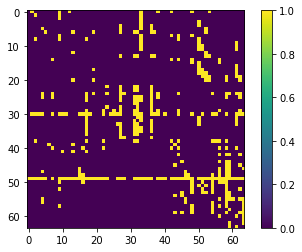

In [6]:
plt.imshow(eo_adj);
plt.colorbar()
plt.show()

{0: 'Fc5.', 1: 'Fc3.', 2: 'Fc1.', 3: 'Fcz.', 4: 'Fc2.', 5: 'Fc4.', 6: 'Fc6.', 7: 'C5..', 8: 'C3..', 9: 'C1..', 10: 'Cz..', 11: 'C2..', 12: 'C4..', 13: 'C6..', 14: 'Cp5.', 15: 'Cp3.', 16: 'Cp1.', 17: 'Cpz.', 18: 'Cp2.', 19: 'Cp4.', 20: 'Cp6.', 21: 'Fp1.', 22: 'Fpz.', 23: 'Fp2.', 24: 'Af7.', 25: 'Af3.', 26: 'Afz.', 27: 'Af4.', 28: 'Af8.', 29: 'F7..', 30: 'F5..', 31: 'F3..', 32: 'F1..', 33: 'Fz..', 34: 'F2..', 35: 'F4..', 36: 'F6..', 37: 'F8..', 38: 'Ft7.', 39: 'Ft8.', 40: 'T7..', 41: 'T8..', 42: 'T9..', 43: 'T10.', 44: 'Tp7.', 45: 'Tp8.', 46: 'P7..', 47: 'P5..', 48: 'P3..', 49: 'P1..', 50: 'Pz..', 51: 'P2..', 52: 'P4..', 53: 'P6..', 54: 'P8..', 55: 'Po7.', 56: 'Po3.', 57: 'Poz.', 58: 'Po4.', 59: 'Po8.', 60: 'O1..', 61: 'Oz..', 62: 'O2..', 63: 'Iz..'}


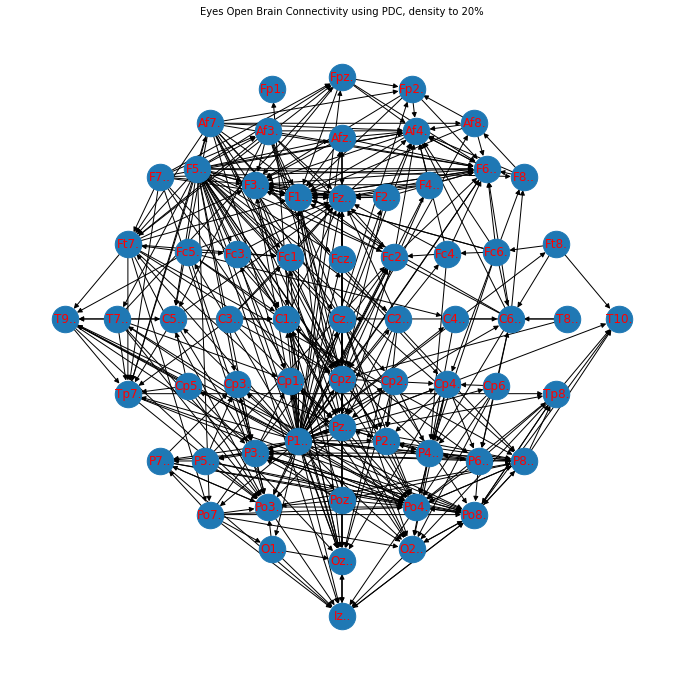

In [13]:
position=pd.read_csv('channel_locations.txt', sep='\s+')

def create_graph(position, adj_mat, title, savefile):
    G = nx.DiGraph(adj_mat)
    #rename labels
    labels={}
    for i in range(0, 64):
        labels[i]=position['label'][i]
    print(labels)
    G= nx.relabel_nodes(G,labels) 
    #create a pos dictionary to pass the position to the nodes of our graph
    pos={}
    for i in range(0, 64):
        pos[position['label'][i]]=[position['x'][i],position['y'][i]]

    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    ax.set_title(title, fontsize=10)

    nx.draw(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos=pos, font_color='red')
    #nx.draw(G_open, with_labels=True)

    #plt.savefig(savefile, format="PNG")
    plt.show()
    
create_graph(position, eo_adj, 'Eyes Open Brain Connectivity using PDC, density to 20%', "PDC_eyes_open.png")

## we repeat the procedure for the eyes closed experiment

In [ ]:
current_dir = os.getcwd()
subject = "S079"
sub_edf = "S079R02.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#ec stands for eyes closed, it is the numpy array corresponding to the second run
ec = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    ec[i, :] = f.readSignal(i)


#fitting in the model for ec with method yule-walker
model_ec = cp.Mvar().fit(ec, method = "yw")

#compute PDC
ec_pdc=cp.conn.pdc_fun(model_ec[0],model_ec[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = ec_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_pdc > threshold).astype(int)

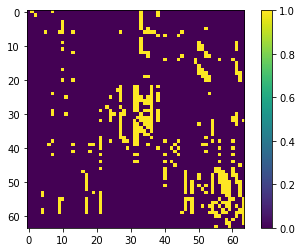

In [11]:
plt.imshow(ec_adj);
plt.colorbar()
plt.show()

{0: 'Fc5.', 1: 'Fc3.', 2: 'Fc1.', 3: 'Fcz.', 4: 'Fc2.', 5: 'Fc4.', 6: 'Fc6.', 7: 'C5..', 8: 'C3..', 9: 'C1..', 10: 'Cz..', 11: 'C2..', 12: 'C4..', 13: 'C6..', 14: 'Cp5.', 15: 'Cp3.', 16: 'Cp1.', 17: 'Cpz.', 18: 'Cp2.', 19: 'Cp4.', 20: 'Cp6.', 21: 'Fp1.', 22: 'Fpz.', 23: 'Fp2.', 24: 'Af7.', 25: 'Af3.', 26: 'Afz.', 27: 'Af4.', 28: 'Af8.', 29: 'F7..', 30: 'F5..', 31: 'F3..', 32: 'F1..', 33: 'Fz..', 34: 'F2..', 35: 'F4..', 36: 'F6..', 37: 'F8..', 38: 'Ft7.', 39: 'Ft8.', 40: 'T7..', 41: 'T8..', 42: 'T9..', 43: 'T10.', 44: 'Tp7.', 45: 'Tp8.', 46: 'P7..', 47: 'P5..', 48: 'P3..', 49: 'P1..', 50: 'Pz..', 51: 'P2..', 52: 'P4..', 53: 'P6..', 54: 'P8..', 55: 'Po7.', 56: 'Po3.', 57: 'Poz.', 58: 'Po4.', 59: 'Po8.', 60: 'O1..', 61: 'Oz..', 62: 'O2..', 63: 'Iz..'}


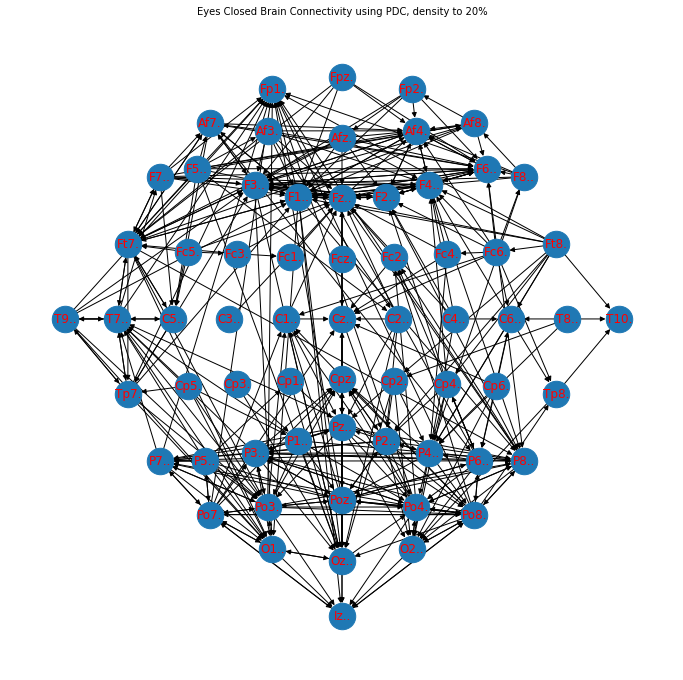

In [14]:
position = pd.read_csv('channel_locations.txt', sep='\s+')

create_graph(position, ec_adj, 'Eyes Closed Brain Connectivity using PDC, density to 20%', "PDC_eyes_closed.png")